# Integrantes

- Vicente Rosales
- Nicolas Fuentes

## Codigo

In [25]:
import numpy as np
import pandas as pd
import time
import tracemalloc
import matplotlib.pyplot as plt

In [21]:
# ---- Header ---- #

# def evaluar_solucion(sol_bin, valores, pesos, capacidades, alpha=0.5)

# def sigmoide(x)

# def binarizar(cont)

# def sho_binario(valores, pesos, capacidades, n_hienas, max_iter, h_max=5.0, h_min=0.0, alpha)

# def leer_instancia_mkp(archivo) 

# ---- Header ---- #

def leer_instancia_mkp(archivo):
    """
    Lee una instancia de MKP desde un archivo en formato OR-Library.
    Retorna: n_items, n_dims, valores, pesos (n_items x n_dims), capacidades
    """
    with open(archivo, 'r') as f:
        lineas = f.readlines()

    idx = 0
    bloques = int(lineas[idx])  # bloques de ítems (por si se usa)
    idx += 1

    n_items, n_dims, _ = map(int, lineas[idx].split())
    idx += 1

    # Leer valores de los ítems
    valores = []
    while len(valores) < n_items:
        valores.extend(map(int, lineas[idx].split()))
        idx += 1

    # Leer pesos por dimensión
    pesos = []
    for d in range(n_dims):
        pesos_dim = []
        while len(pesos_dim) < n_items:
            pesos_dim.extend(map(int, lineas[idx].split()))
            idx += 1
        pesos.append(pesos_dim)
    pesos = np.array(pesos).T  # convertir a (n_items x n_dims)

    # Leer capacidades
    capacidades = []
    while len(capacidades) < n_dims:
        capacidades.extend(map(int, lineas[idx].split()))
        idx += 1

    return n_items, n_dims, np.array(valores), pesos, np.array(capacidades)
def sigmoide(x):
    """Función sigmoide logística."""
    return 1.0 / (1.0 + np.exp(-x))

def binarizar(cont):
    """
    Convierte un vector continuo a binario usando sigmoid + criterio probabilístico.
    cont: array de floats
    retorna: array de 0/1
    """
    prob = sigmoide(cont)
    return (np.random.rand(*cont.shape) < prob).astype(int)

def evaluar_solucion(sol_bin, valores, pesos, capacidades, alpha):
    """
    Calcula el fitness de una solución binaria para MKP con penalización.
    sol_bin: vector 0/1 de selección de ítems
    valores: vector de valores de cada ítem
    pesos: matriz (n_items x n_dims) de pesos
    capacidades: vector de capacidades por dimensión
    alpha: factor de penalización
    retorna: fitness (float), es_factible (bool)
    """
    total_valor = np.dot(sol_bin, valores)
    peso_total = pesos.T.dot(sol_bin)
    exceso = np.maximum(0, peso_total - capacidades)
    penalizacion = alpha * exceso.sum()
    fitness = total_valor - penalizacion
    factible = np.all(exceso <= 0)
    return fitness, factible

def sho_binario(valores, pesos, capacidades, n_hienas, max_iter, alpha, h_max=5.0, h_min=0.0):
    """
    Spotted Hyena Optimizer (binario) para MKP.
    Retorna:
      mejor_bin: vector binario de la mejor solución
      mejor_fitness: fitness de la mejor solución
      presa_inicial: mejor fitness en la población inicial
      mejor_presa: mejor fitness encontrado a lo largo de todas las iteraciones
      peor_presa: peor fitness encontrado a lo largo de todas las iteraciones
    """
    
    valores_hienas = []
    n_items = len(valores)
    
    # 1. Inicializar población continua en [-1,1]
    poblacion_cont = np.random.uniform(-1, 1, size=(n_hienas, n_items))
    
    # 2. Evaluar población inicial
    presa_inicial = -np.inf
    mejor_presa = -np.inf
    peor_presa =  np.inf
    mejor_bin = np.zeros(n_items, dtype=int)
    mejor_fitness = -np.inf
    mejor_cont = None
    
    for i in range(n_hienas):
        cont = poblacion_cont[i]
        binario = binarizar(cont)
        fitness, factible = evaluar_solucion(binario, valores, pesos, capacidades, alpha)
        presa_inicial = max(presa_inicial, fitness)
        mejor_presa = max(mejor_presa, fitness)
        peor_presa = min(peor_presa, fitness)
        if fitness > mejor_fitness:
            mejor_fitness = fitness
            mejor_bin = binario.copy()
            mejor_cont = cont.copy()

        if fitness not in valores_hienas:
            valores_hienas.append(fitness)
        
    # 3. Bucle de iteraciones
    for it in range(max_iter):
        # 3.1 actualizar factor de exploración/explotación
        h = h_max - (it * (h_max - h_min) / max_iter)
        
        # 3.2 evaluar cada hiena y actualizar presas
        for i in range(n_hienas):
            cont = poblacion_cont[i]
            binario = binarizar(cont)
            fitness, factible = evaluar_solucion(binario, valores, pesos, capacidades, alpha)
            mejor_presa = max(mejor_presa, fitness)
            peor_presa = min(peor_presa, fitness)
            if fitness > mejor_fitness:
                mejor_fitness = fitness
                mejor_bin = binario.copy()
                mejor_cont = cont.copy()
        
        # 3.3 mover hienas alrededor de la presa
        for i in range(n_hienas):
            if mejor_cont is None:
                break
            X = poblacion_cont[i]
            r1 = np.random.rand(n_items)
            r2 = np.random.rand(n_items)
            B = 2.0 * r1
            E = 2.0 * h * r2 - h
            D = np.abs(B * mejor_cont - X)
            poblacion_cont[i] = mejor_cont - E * D
    
    print("=========== INFO FINAL ===========")
    print("Presa inicial:", presa_inicial)
    print("Mejor presa  :", mejor_presa)
    print("Peor presa   :", peor_presa)
    print("delta        :", np.abs(mejor_presa - presa_inicial))
    print()

    return mejor_bin, mejor_fitness, presa_inicial, mejor_presa, peor_presa, factible, valores_hienas

In [6]:
# Parámetros
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_items = 10       # Número de ítems
n_dims = 3         # Número de restricciones (en el fondo son las dimensiones)
n_hienas = 40      # Tamaño de la población
max_iter = 100     # Número de iteraciones

# Leer instancia fácil
n_items_faciles, n_dims_faciles, valores_faciles, pesos_faciles, capacidades_faciles = leer_instancia_mkp("Instancias/mknapcb1.txt")

# Leer instancia media
n_items_dificiles, n_dims_media, valores_media, pesos_media, capacidades_media = leer_instancia_mkp("Instancias/mknapcb5.txt")

# Leer instancia difícil
n_items_dificiles, n_dims_dificiles, valores_dificiles, pesos_dificiles, capacidades_dificiles = leer_instancia_mkp("Instancias/mknapcb9.txt")

## Pruebas

### Generales

In [22]:
results = []
instancias_txt = {
    'Fácil': 'Instancias/mknapcb1.txt',
    'Media': 'Instancias/mknapcb5.txt',
    'Difícil': 'Instancias/mknapcb9.txt',
}

# --- Parametros de la optimización --- #
n_runs = 10
n_hienas = 50
max_iter = 100
alpha = 2
# ------------------------------------- #

for nombre, archivo in instancias_txt.items():
    n_items, n_dims, valores, pesos, capacidades = leer_instancia_mkp(archivo)
    for _ in range(n_runs):
        
        # Inicializar seguimiento de tiempo y memoria
        tiempo_inicio = time.time()
        memoria_inicio = tracemalloc.start() 

        mejor_bin, mejor_valor, presa_inicial, mejor_presa, peor_presa, factible, lista_valores = sho_binario(
            valores, pesos, capacidades, n_hienas, max_iter, alpha
        )

        # Finalizar seguimiento de tiempo y memoria
        actual, peak = tracemalloc.get_traced_memory()
        tiempo_final = time.time()
        tiempo_ejecucion = tiempo_final - tiempo_inicio
        memoria_utilizada = peak / (1024 * 1024)
        tracemalloc.stop()

        # Calcular delta
        delta = mejor_valor - presa_inicial

        results.append({
            'Instancia': nombre,
            'Mejor': mejor_valor,
            'Presa inicial': presa_inicial,
            'Delta': delta,
            'Factibilidad': factible,
            'Tiempo de ejecución': tiempo_ejecucion,
            'Memoria utilizada (MB)': memoria_utilizada,
            'Valores de las presas': lista_valores
        })

# Pasar a DataFrame
df_resultados = pd.DataFrame(results)

# Faciles
df_faciles = df_resultados.loc[df_resultados['Instancia'] == 'Fácil']
df_faciles["% de mejora"] = (df_faciles["Mejor"] - df_faciles["Presa inicial"]) / np.abs(df_faciles["Presa inicial"]) * 100
df_faciles["Mean"] = df_faciles["Mejor"].mean().__round__(2)
df_faciles["Std deviation"] = df_faciles["Mejor"].std()

# Medios
df_medios = df_resultados.loc[df_resultados['Instancia'] == 'Media']
df_medios["% de mejora"] = (df_medios["Mejor"] - df_medios["Presa inicial"]) / np.abs(df_medios["Presa inicial"]) * 100
df_medios["Mean"] = df_medios["Mejor"].mean()
df_medios["Std deviation"] = df_medios["Mejor"].std()

# Dificiles
df_dificiles = df_resultados.loc[df_resultados['Instancia'] == 'Difícil']
df_dificiles["% de mejora"] = (df_dificiles["Mejor"] - df_dificiles["Presa inicial"]) / np.abs(df_dificiles["Presa inicial"]) * 100
df_dificiles["Mean"] = df_dificiles["Mejor"].mean()
df_dificiles["Std deviation"] = df_dificiles["Mejor"].std()


/tmp/ipykernel_5580/3022368624.py:55: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


=========== INFO FINAL ===========
Presa inicial: -48447
Mejor presa  : 20888
Peor presa   : -162481
delta        : 69335

=========== INFO FINAL ===========
Presa inicial: -45897
Mejor presa  : 19175
Peor presa   : -164464
delta        : 65072

=========== INFO FINAL ===========
Presa inicial: -43076
Mejor presa  : 19218
Peor presa   : -171065
delta        : 62294

=========== INFO FINAL ===========
Presa inicial: -40808
Mejor presa  : 20437
Peor presa   : -164843
delta        : 61245

=========== INFO FINAL ===========
Presa inicial: -18087
Mejor presa  : 19404
Peor presa   : -159073
delta        : 37491

=========== INFO FINAL ===========
Presa inicial: -41301
Mejor presa  : 19325
Peor presa   : -162583
delta        : 60626

=========== INFO FINAL ===========
Presa inicial: -37216
Mejor presa  : 20029
Peor presa   : -159120
delta        : 57245

=========== INFO FINAL ===========
Presa inicial: -44496
Mejor presa  : 20811
Peor presa   : -166221
delta        : 65307

=========== INFO

/tmp/ipykernel_5580/1061496257.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faciles["% de mejora"] = (df_faciles["Mejor"] - df_faciles["Presa inicial"]) / np.abs(df_faciles["Presa inicial"]) * 100
/tmp/ipykernel_5580/1061496257.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faciles["Mean"] = df_faciles["Mejor"].mean().__round__(2)
/tmp/ipykernel_5580/1061496257.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Instancia facil

In [23]:
df_faciles

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),Valores de las presas,% de mejora,Mean,Std deviation
0,Fácil,20888,-48447,69335,False,1.280551,0.062845,"[-72276, -107633, -87596, -112698, -74007, -91...",143.115157,20028.8,691.542848
1,Fácil,19175,-45897,65072,False,1.274923,0.052976,"[-89426, -92948, -102785, -111859, -70708, -12...",141.778330,20028.8,691.542848
2,Fácil,19218,-43076,62294,False,1.272140,0.054564,"[-82839, -77246, -143560, -71000, -77415, -446...",144.614170,20028.8,691.542848
3,Fácil,20437,-40808,61245,True,1.242682,0.055713,"[-91329, -68888, -100920, -99826, -59819, -924...",150.080866,20028.8,691.542848
4,Fácil,19404,-18087,37491,False,1.317771,0.055645,"[-50954, -105430, -90001, -108912, -103883, -9...",207.281473,20028.8,691.542848
5,Fácil,19325,-41301,60626,False,1.324703,0.055690,"[-55915, -75569, -52788, -97255, -68951, -8489...",146.790635,20028.8,691.542848
6,Fácil,20029,-37216,57245,False,1.344807,0.055464,"[-76657, -87214, -88081, -87952, -53149, -3721...",153.818250,20028.8,691.542848
7,Fácil,20811,-44496,65307,False,1.284602,0.055713,"[-110648, -51949, -84078, -88603, -99877, -757...",146.770496,20028.8,691.542848
8,Fácil,20688,-37999,58687,False,1.296981,0.055713,"[-37999, -104468, -67299, -64320, -105690, -94...",154.443538,20028.8,691.542848
9,Fácil,20313,-27151,47464,True,1.277416,0.055713,"[-72595, -70717, -113830, -58119, -60826, -716...",174.814924,20028.8,691.542848


### Instancia media

In [16]:
df_medios

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),% de mejora,Mean,Std deviation
10,Media,45540,-338171,383711,False,1.300623,0.119545,113.466560,8290.1,86865.774313
11,Media,-232578,-290831,58253,False,1.227730,0.120533,20.029846,8290.1,86865.774313
12,Media,41984,-321267,363251,False,1.268618,0.120506,113.068258,8290.1,86865.774313
13,Media,-18384,-392444,374060,False,1.268783,0.120504,95.315510,8290.1,86865.774313
14,Media,44194,-364587,408781,False,1.228512,0.120506,112.121661,8290.1,86865.774313
15,Media,48345,-347990,396335,False,1.299624,0.120373,113.892641,8290.1,86865.774313
16,Media,41361,-340337,381698,False,1.179749,0.120504,112.152954,8290.1,86865.774313
17,Media,37208,-361326,398534,False,1.226389,0.120373,110.297626,8290.1,86865.774313
18,Media,45225,-379589,424814,False,1.235165,0.118454,111.914202,8290.1,86865.774313
19,Media,30006,-391301,421307,False,1.237431,0.119106,107.668266,8290.1,86865.774313


### Instancia dificil

In [47]:
df_dificiles

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),Valores de las presas,% de mejora,Mean,Std deviation
20,Difícil,-797175,-3008000,2210825,False,1.542797,0.234786,"[-3819869, -3881416, -3095074, -3433294, -3481...",73.498172,-818221.7,423900.79826
21,Difícil,-407451,-2765016,2357565,False,1.406574,0.235198,"[-3774333, -3522178, -4387723, -4163473, -3864...",85.264064,-818221.7,423900.79826
22,Difícil,-1072763,-3116284,2043521,False,1.514514,0.234246,"[-3308520, -4121341, -3201591, -3748682, -3545...",65.575570,-818221.7,423900.79826
23,Difícil,-115657,-2721303,2605646,False,1.354582,0.233051,"[-4182750, -3472359, -3652523, -3525366, -3380...",95.749940,-818221.7,423900.79826
24,Difícil,-416053,-2716689,2300636,False,1.548306,0.234246,"[-3421137, -3223557, -3864199, -3704344, -3888...",84.685292,-818221.7,423900.79826
25,Difícil,-841697,-2737512,1895815,False,1.334742,0.234671,"[-2868861, -3226515, -3614081, -3785926, -4098...",69.253212,-818221.7,423900.79826
26,Difícil,-947650,-2736377,1788727,False,1.440726,0.235379,"[-3084105, -3321518, -3427671, -3951688, -3061...",65.368442,-818221.7,423900.79826
27,Difícil,-1238465,-2863765,1625300,False,1.515829,0.235622,"[-4410785, -3384522, -2906003, -3401956, -3266...",56.753959,-818221.7,423900.79826
28,Difícil,-1548667,-2657322,1108655,False,1.481303,0.234573,"[-3448953, -2657322, -3771259, -3486614, -3715...",41.720762,-818221.7,423900.79826
29,Difícil,-796639,-2738702,1942063,False,1.379524,0.234716,"[-3672728, -4095311, -3427172, -3241528, -3393...",70.911804,-818221.7,423900.79826


## Analisis grafico

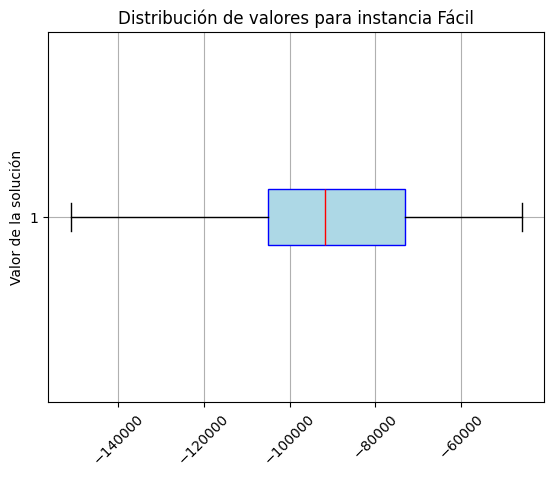

In [59]:
valores_hienas_faciles = df_faciles.loc[1,"Valores de las presas"]

plt.boxplot(valores_hienas_faciles, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.title('Distribución de valores para instancia Fácil')
plt.ylabel('Valor de la solución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

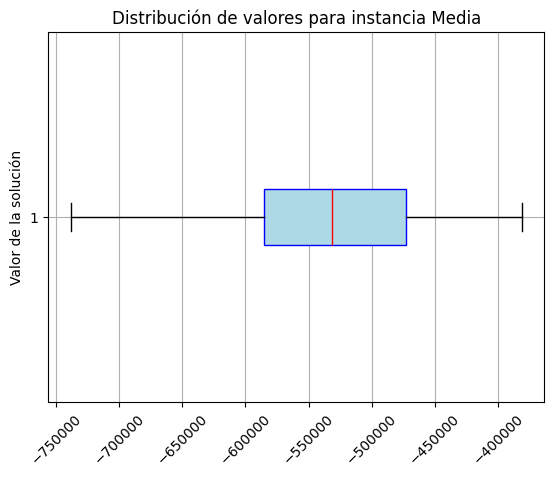

In [60]:
valores_hienas_medios = df_medios.loc[11,"Valores de las presas"]

plt.boxplot(valores_hienas_medios, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.title('Distribución de valores para instancia Media')
plt.ylabel('Valor de la solución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

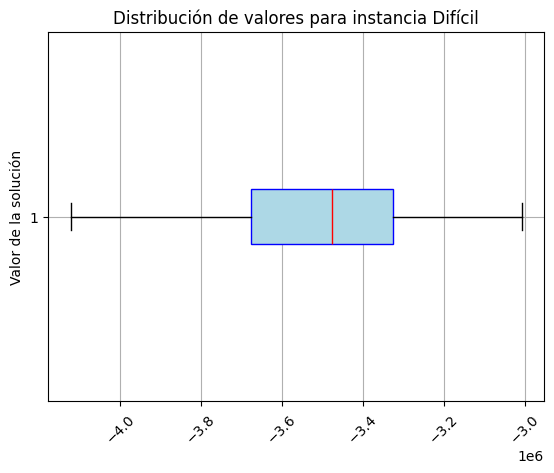

In [61]:
valores_hienas_dificiles = df_dificiles.loc[20,"Valores de las presas"]

plt.boxplot(valores_hienas_dificiles, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.title('Distribución de valores para instancia Difícil')
plt.ylabel('Valor de la solución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

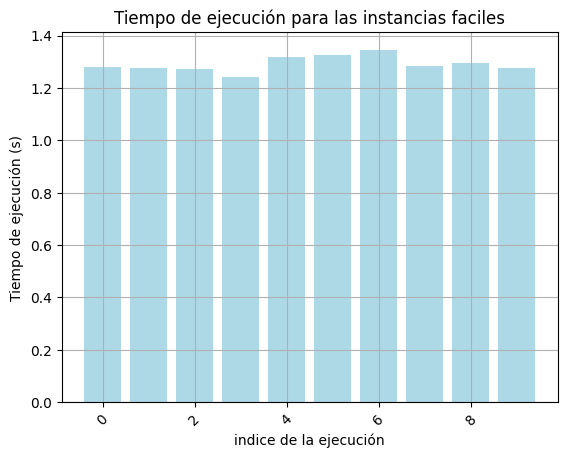

In [68]:
plt.bar(df_faciles.index, df_faciles["Tiempo de ejecución"], label='Fácil', color='lightblue')
plt.title('Tiempo de ejecución para las instancias faciles')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

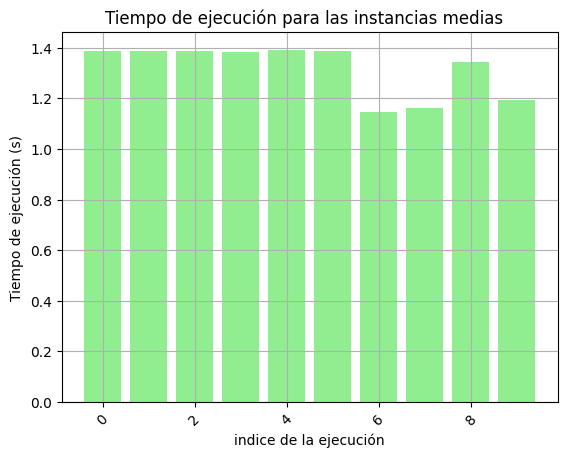

In [70]:
plt.bar(df_faciles.index, df_medios["Tiempo de ejecución"], label='Media', color='lightgreen')
plt.title('Tiempo de ejecución para las instancias medias  ')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

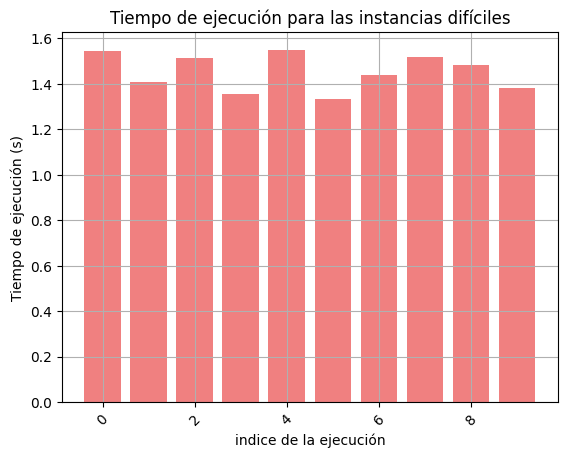

In [69]:
plt.bar(df_faciles.index, df_dificiles["Tiempo de ejecución"], label='Difícil', color='lightcoral')
plt.title('Tiempo de ejecución para las instancias difíciles')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()